In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.parsing.preprocessing import remove_stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression

sns.set_theme()
print("Modules imported!")

Modules imported!


In [ ]:
df = pd.read_csv("drive/MyDrive/IMDB Dataset.csv")
print(df)

                                                  review sentiment
0      One of the other reviewers has mentioned that ...  positive
1      A wonderful little production. <br /><br />The...  positive
2      I thought this was a wonderful way to spend ti...  positive
3      Basically there's a family where a little boy ...  negative
4      Petter Mattei's "Love in the Time of Money" is...  positive
...                                                  ...       ...
49995  I thought this movie did a down right good job...  positive
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
49997  I am a Catholic taught in parochial elementary...  negative
49998  I'm going to have to disagree with the previou...  negative
49999  No one expects the Star Trek movies to be high...  negative

[50000 rows x 2 columns]


In [ ]:
df['length'] = df['review'].apply(lambda text: len(text))
df = df[df['length']<500]
df_pos = df[df['sentiment']=='positive'][:2232]
df_neg = df[df['sentiment']=='negative']
df = df_neg.append(df_pos)
print(df)

                                                  review sentiment  length
36     The plot is about the death of little children...  negative     494
46     Protocol is an implausible movie whose only sa...  negative     434
63     Besides being boring, the scenes were oppressi...  negative     267
84     We brought this film as a joke for a friend, a...  negative     402
112    It's terrific when a funny movie doesn't make ...  negative     226
...                                                  ...       ...     ...
40826  "Fear Of A Black Hat" is everything the (much ...  positive     384
40843  I just finished this movie and my only comment...  positive     399
40865  Well-done ghost story that will give you the c...  positive     358
40871  When I saw this as a child, it answered all of...  positive     413
40895  In conception a splendid film, investigating t...  positive     418

[4464 rows x 3 columns]


In [ ]:
def messy2text(messy):
  messy = messy.lower()
  messy = messy.replace("<br />", "")
  messy = ''.join([i for i in messy if i.isalpha() or i.isspace()])
  messy = ' '.join(messy.split())
  messy = remove_stopwords(messy)
  return messy

df['review'] = df['review'].apply(lambda messy: messy2text(messy))
print(np.array(df['review']))

['plot death little children hopper investigate killings movie appears troubles daughter end serial killer caught thats dunnit terrible acting actors unbelievable bad actors including hopper like waste time dont watch movie ive warned'
 'protocol implausible movie saving grace stars goldie hawn good cast supporting actors story revolves ditzy cocktail waitress famous inadvertently saving life arab dignitary story goes downhill halfway movie goldies charm doesnt save movie goldie hawn fan dont way film'
 'boring scenes oppressive dark movie tried portray kind moral fell flat message redeeming qualities dont think librarians look unglamorous'
 ...
 'welldone ghost story creeps pretty fair scares way story unfolds slowly building atmosphere way youre ready woman black wont forget youve seen gore knives hockey masksjust wellconstructed story best viewed night lights'
 'saw child answered questions dispelled fears misconceptions easy watch animated makes unthreatening moral bias preachy asp

In [ ]:
df['sentiment'] = df['sentiment'].map({'positive':1, 'negative':0})
print(df['sentiment'].isna().sum())
print(df['sentiment'])

0
36       0
46       0
63       0
84       0
112      0
        ..
40826    1
40843    1
40865    1
40871    1
40895    1
Name: sentiment, Length: 4464, dtype: int64


In [ ]:
X = np.array(df['review'])
y = np.array(df['sentiment'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3348,) (3348,)
(1116,) (1116,)


In [ ]:
model = Pipeline([
    ('count', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('scale', MaxAbsScaler()),
    ('log', LogisticRegression()) 
])

model.fit(X_train, y_train)

print(model.score(X_test, y_test))

0.8637992831541219


In [ ]:
print(X_train[0])
print(y_train[0])

redundant case enjoy snl comedian antics case schneider basic comedy mans life saved having animal organs transplanted unfortunately takes animals characteristics survivor colleen looks pretty good doesnt open sores legs little makeup face d
0


In [ ]:
def predict_review(review):
  reviews = [messy2text(r) for r in review]
  preds = model.predict(reviews)
  preds_list = list(preds.flatten())
  return preds

print(predict_review(['I absolutely loved this movie!', 'This movie was horrible', 'The movie was cool', 'The movie needed improvements']))

[1 0 1 0]


In [ ]:
!pip install praw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 188 kB 14.5 MB/s 
     |████████████████████████████████| 54 kB 2.9 MB/s 


In [ ]:
import praw

r = praw.Reddit(client_id="hiW4WeqGUEDOhTnXs7rOOg",
                client_secret="0WPSpVC7JYs_hl0XzWuLoufdAqeouA",
                user_agent="TrickyPresence4543",
)

def url2comments(url, minChar, numComments):
  submission = r.submission(url=url)
  submission.comment_sort = 'top'

  comments = []
  for comment in submission.comments.list():
    c = messy2text(comment.body)
    if not comment.stickied and len(c) >= minChar:
      comments.append(c)
      if len(comments) == numComments:
        break
  
  return comments

In [ ]:
with open('drive/MyDrive/themovies.txt', 'r') as allmovies:
  URLS = list(allmovies.readlines())
  the_split = [l.rstrip().split() for l in URLS if len(l.rstrip()) > 0]
  links = [t[0] for t in the_split]
  imdb = [float(t[1]) for t in the_split]
  rotten = [int(t[2]) for t in the_split]

all_comments = []
for link in links: 
  comments = url2comments(link, 100, 20)
  all_comments.append(comments)

print(np.array(all_comments).shape)

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

(50, 20)


In [ ]:
print(np.array(all_comments).shape)
preds = predict_review(np.array(all_comments).flatten())
comment_scores = np.array(preds).reshape(-1,20)

print(comment_scores.shape)

(50, 20)
(50, 20)


In [ ]:
preds = [[predict_review([c])[0] for c in comments] for comments in all_comments]
print(preds)

[[1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1], [1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1], [1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1], [0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0], [1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1], [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0], [1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0], [0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1], [1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1], [1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0], [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1], [1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1], [0, 0, 

In [ ]:
def link2movie(link):
  title = link[:-1].split('/')[-1]
  movie_words = title.split('_')[2:]

  if 'spoilers' in link:
    movie_words = title.split('_')[2:-1]
    
  movie = ' '.join(movie_words)
  return movie

avgs = [np.mean(s) for s in comment_scores]
movies = [link2movie(l) for l in links]

movie2correct = {'everything everywhere all at':'once', 'spiderman into the':'spiderverse', 'shangchi and the legend of':'the ten rings',
                 'star wars episode vii the':'force awakens', 'doctor strange in the':'multiverse of madness', 
                 'star wars episode viii the':'last jedi', 'star wars episode ix':'the rise of skywalker', 
                 'batman v superman dawn of':'justice'}
for i in range(len(movies)):
  if movies[i] in movie2correct.keys():
    movies[i] += ' ' + movie2correct[movies[i]]

movie2score = {movie: score for movie, score in zip(movies, avgs)}
movie2score = {movie: score for movie, score in sorted(movie2score.items(), key=lambda item: item[1], reverse=True)}

i = 1
for movie, score in movie2score.items():
  print(f"{i}. {movie}: {score}")
  i += 1

1. everything everywhere all at once: 0.95
2. black panther: 0.9
3. soul: 0.9
4. spiderman homecoming: 0.9
5. the suicide squad: 0.85
6. avengers infinity war: 0.8
7. avengers endgame: 0.8
8. the batman: 0.8
9. spiderman into the spiderverse: 0.8
10. arrival: 0.8
11. spiderman far from home: 0.8
12. spiderman no way home: 0.75
13. rogue one a star wars story: 0.75
14. deadpool 2: 0.75
15. dune: 0.75
16. logan: 0.75
17. guardians of the galaxy vol 2: 0.75
18. parasite: 0.75
19. shangchi and the legend of the ten rings: 0.75
20. captain marvel: 0.75
21. wonder woman: 0.75
22. captain america civil war: 0.75
23. joker: 0.7
24. star wars episode vii the force awakens: 0.7
25. annihilation: 0.7
26. baby driver: 0.7
27. thor ragnarok us release: 0.7
28. it: 0.65
29. us: 0.65
30. dunkirk: 0.65
31. incredibles 2: 0.65
32. doctor strange in the multiverse of madness: 0.6
33. once upon a time in hollywood: 0.6
34. deadpool: 0.6
35. dont look up: 0.6
36. godzilla vs kong: 0.6
37. el camino a brea

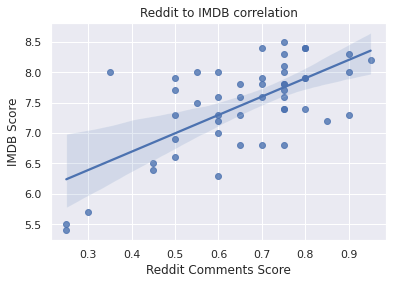

In [ ]:
sns.regplot(x=avgs, y=imdb)
plt.xlabel('Reddit Comments Score')
plt.ylabel('IMDB Score')
plt.title('Reddit to IMDB correlation')
plt.show()

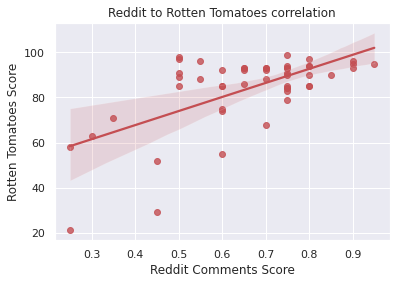

In [ ]:
sns.regplot(x=avgs, y=rotten, color='r')
plt.xlabel('Reddit Comments Score')
plt.ylabel('Rotten Tomatoes Score')
plt.title('Reddit to Rotten Tomatoes correlation')
plt.show()

In [ ]:
print("IMDB Correlation: " + str(np.corrcoef(avgs, imdb)[0][1]))
print("Rotten Tomatoes Correlation: " + str(np.corrcoef(avgs, rotten)[0][1]))

IMDB Correlation: 0.6673702923069915
Rotten Tomatoes Correlation: 0.6258903361672303
